# Automatic Speech Recognition: Finetune Wav2Vec2 for English ASR

**Install Dependencies**

Install both datasets and transformers.
We need the [soundfile](https://pypi.org/project/SoundFile/) package which is based on libsndfile, CFFI and NumPy to load audio files and jiwer to evaluate our model using the word error rate [WER](https://pypi.org/project/jiwer/) metric.

In [2]:
%%capture 

!pip install datasets==1.5.0
!pip install transformers==4.4.0 
!pip install soundfile 
!pip install jiwer 

**Mount Google Drive**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Change working directory. Make sure you have the folders created in your google drive.

In [4]:
%cd /content/gdrive/MyDrive/EnglishASR_ICON/

/content/gdrive/MyDrive/EnglishASR_ICON


# Prepare Data, Tokenizer and Feature Extractor

1. Load dataset: TIMIT (https://huggingface.co/datasets/timit_asr)

TIMIT is an automatic speech recognition dataset. It is one of the first benchmark dataset for Deep Learning based ASR. See here for leaderboard on TIMIT dataset (https://paperswithcode.com/sota/speech-recognition-on-timit)

For demonstration purposes, we use small TIMIT dataset that contains just 5h of training data.






In [6]:
import datasets # importing datasets library
from datasets import load_dataset, load_metric
timit = load_dataset("timit_asr")
print(timit)

Reusing dataset timit_asr (/root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/e7245f262bb418c1a5c67d67e00297322b1ad19eb65223676b790aa8003449e4)


DatasetDict({
    train: Dataset({
        features: ['file', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 4620
    })
    test: Dataset({
        features: ['file', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 1680
    })
})


2. Create a small dataset: For demonstration

In [7]:
timit_small = datasets.DatasetDict() 
# Take samples from index 10 to 19 from the train and test splits. 
timit_small['train'] = load_dataset("timit_asr", split='train[10:20]')
timit_small['test'] = load_dataset("timit_asr", split='test[10:20]')

Reusing dataset timit_asr (/root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/e7245f262bb418c1a5c67d67e00297322b1ad19eb65223676b790aa8003449e4)
Reusing dataset timit_asr (/root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/e7245f262bb418c1a5c67d67e00297322b1ad19eb65223676b790aa8003449e4)


3. Remove unnecessary columns

    We only need wav file and target text.

In [8]:
timit_small = timit_small.remove_columns(["phonetic_detail", "word_detail", "dialect_region", "id", "sentence_type", "speaker_id"])

In [9]:
print(timit_small['test'][0]['file'])
print(timit_small['test'][0]['text'])

/root/.cache/huggingface/datasets/downloads/extracted/404950a46da14eac65eb4e2a8317b1372fb3971d980d91d5d5b221275b1fd7e0/data/TEST/DR4/MTLS0/SI2000.WAV
We can get it if we dig, he said patiently.


**Data Preparation**
4. Remove special characters
    
    In ASR, generally all punctuations except apostrophe and other special characters are removed for training.

In [10]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower()
    return batch

timit_small = timit_small.map(remove_special_characters)

**Data Preparation**
5. Create vocabulary

In [11]:
def extract_all_chars(batch):
  all_text = " ".join(batch["text"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

vocabs = timit_small.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=timit_small.column_names["train"])
print(vocabs)


DatasetDict({
    train: Dataset({
        features: ['all_text', 'vocab'],
        num_rows: 1
    })
    test: Dataset({
        features: ['all_text', 'vocab'],
        num_rows: 1
    })
})


In [12]:
vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))

vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

{' ': 25,
 "'": 6,
 'a': 15,
 'b': 19,
 'c': 10,
 'd': 2,
 'e': 12,
 'f': 5,
 'g': 22,
 'h': 16,
 'i': 4,
 'j': 1,
 'k': 20,
 'l': 7,
 'm': 3,
 'n': 21,
 'o': 17,
 'p': 18,
 'r': 11,
 's': 14,
 't': 24,
 'u': 23,
 'v': 13,
 'w': 8,
 'x': 9,
 'y': 0}

To make it clearer that " " has its own token class, we give it a more visible character |. In addition, we also add an "unknown" token so that the model can later deal with characters not encountered in TIMIT's training set.

Finally, we also add a padding token that corresponds to CTC's "blank token". The "blank token" is a core component of the CTC algorithm.

In [13]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
print(len(vocab_dict))

28


Save vocabulary in json format.

In [14]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

**Fine-tuning Wav2Vec2 for English ASR**

[Wav2Vec2](https://ai.facebook.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/) is a pretrained model for Automatic Speech Recognition (ASR) and was released in September 2020 by Alexei Baevski, Michael Auli, and Alex Conneau (FAIR).

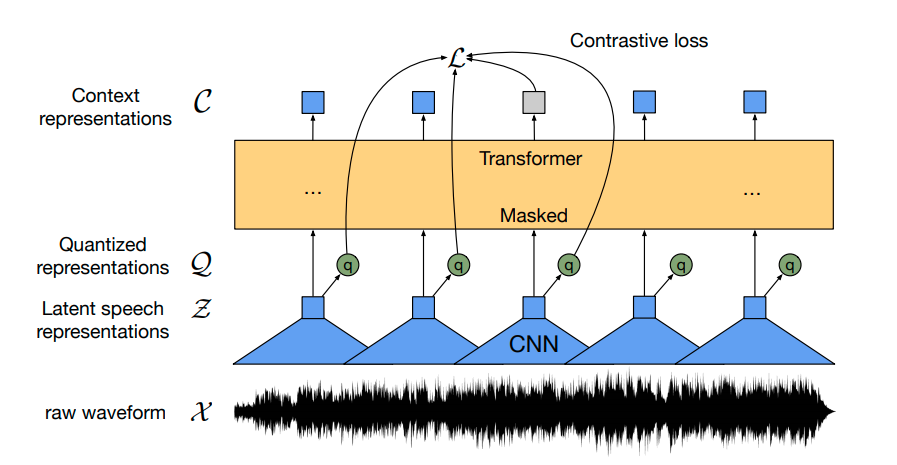

ASR models transcribe speech to text. To preprocess speech (raw audio files), we need a feature extractor that processes the speech signal to the model's input format, e.g. a feature vector. We need a tokenizer that processes the model's output format to text.

In Transformers, the Wav2Vec2 model is thus accompanied by both a tokenizer, called Wav2Vec2CTCTokenizer, and a feature extractor, called Wav2Vec2FeatureExtractor.

**Create Wav2Vec2CTCTokenizer**

The pretrained Wav2Vec2 checkpoint maps the speech signal to a sequence of context representations as illustrated in the figure above. A fine-tuned Wav2Vec2 checkpoint needs to map this sequence of context representations to its corresponding transcription so that a linear layer has to be added on top of the transformer block (shown in yellow). 

The output size of this layer corresponds to the number of tokens in the vocabulary, which does not depend on Wav2Vec2's pretraining task, but only on the labeled dataset used for fine-tuning. 


In [15]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")


**Create Wav2Vec2 Feature Extractor**
Wav2Vec2 was pretrained on the audio data of LibriSpeech and LibriVox which are both sampled at 16kHz. Our fine-tuning dataset, TIMIT, also has the same sampling rate.

A Wav2Vec2 feature extractor object requires the following parameters to be instantiated:

- `feature_size`: Speech models take a sequence of feature vectors as an input. While the length of this sequence obviously varies, the feature size should not. In the case of Wav2Vec2, the feature size is 1 because the model was trained on the raw speech signal ${}^2$.
- `sampling_rate`: The sampling rate at which the model is trained on.
- `padding_value`: For batched inference, shorter inputs need to be padded with a specific value.
- `do_normalize`: Whether the input should be *zero-mean-unit-variance* normalized or not. Usually, speech models perform better when normalizing the input
- `return_attention_mask`: Whether the model should make use of an `attention_mask` for batched inference. In general, models should **always** make use of the `attention_mask` to mask padded tokens. However, due to a very specific design choice of `Wav2Vec2`'s "base" checkpoint, better results are achieved when using no `attention_mask`. This is **not** recommended for other speech models. For more information, one can take a look at [this](https://github.com/pytorch/fairseq/issues/3227) issue. 


In [16]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

**Create Wav2Vec2Processor** 

To make the usage of Wav2Vec2 as user-friendly as possible, the feature extractor and tokenizer are *wrapped* into a single `Wav2Vec2Processor` class so that one only needs a `model` and `processor` object.

In [17]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

**Preprocess Data**

The audio file is saved in the .WAV format. We will use soundfile  for loading audio files.

An audio file usually stores both its values and the sampling rate with which the speech signal was digitalized. We want to store both in the dataset and write a map(...) function accordingly.

In [18]:
import soundfile as sf

def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = sf.read(batch["file"])
    batch["speech"] = speech_array
    batch["sampling_rate"] = sampling_rate
    batch["target_text"] = batch["text"]
    return batch

timit_small = timit_small.map(speech_file_to_array_fn, num_proc=4)

**Prepare Data**

We process the dataset to the format expected by the model for training.

First, we check that all data samples have the same sampling rate (of 16kHz). Second, we extract the input_values from the loaded audio file. Third, we encode the transcriptions to label ids.

In [19]:
def prepare_dataset(batch):
    # check that all files have the correct sampling rate
    assert (
        len(set(batch["sampling_rate"])) == 1
    ), f"Make sure all inputs have the same sampling rate of {processor.feature_extractor.sampling_rate}."

    batch["input_values"] = processor(batch["speech"], sampling_rate=batch["sampling_rate"][0]).input_values

    with processor.as_target_processor():
        batch["labels"] = processor(batch["target_text"]).input_ids
    return batch

timit_prepared = timit_small.map(prepare_dataset, remove_columns=timit_small.column_names["train"], batch_size=8, num_proc=4, batched=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


**Listen to sample audio in train set.**

In [20]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(timit_small["train"])-1)

ipd.Audio(data=np.asarray(timit_small["train"][rand_int]["speech"]), autoplay=False, rate=16000)

**Check that the data is correctly prepared.**

In [21]:
import numpy as np
rand_int = random.randint(0, len(timit_small["train"])-1)

print("Target text:", timit_small["train"][rand_int]["target_text"])
print("Input array shape:", np.asarray(timit_small["train"][rand_int]["speech"]).shape)
print("Sampling rate:", timit_small["train"][rand_int]["sampling_rate"])

Target text: the dead spirits occupied a prominent place in every hope and in every fear
Input array shape: (76800,)
Sampling rate: 16000


# Training 

**Define a Data Collator and Load metric**
The data is processed so that we are ready to start setting up the training pipeline. We will make use of [Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer) for which we essentially need to do the following:

- Define a data collator. In contrast to most NLP models, Wav2Vec2 has a much larger input length than output length. *E.g.*, a sample of input length 50000 has an output length of no more than 100. Given the large input sizes, it is much more efficient to pad the training batches dynamically meaning that all training samples should only be padded to the longest sample in their batch and not the overall longest sample. Therefore, fine-tuning Wav2Vec2 requires a special padding data collator, which we will define below.

- Evaluation metric. During training, the model should be evaluated on the word error rate. We should define a `compute_metrics` function accordingly.

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the test data and verify that it has indeed learned to correctly transcribe speech.

### Set-up Trainer

Let's start by defining the data collator. The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81).

This data collator treats the `input_values` and `labels` differently and thus applies separate padding functions on them (again making use of Wav2Vec2's context manager). This is necessary because in speech input and output are of different modalities meaning that they should not be treated by the same padding function.
Analogous to common data collators, the padding tokens in the labels are replaced with `-100` so that those tokens are **not** taken into account when computing the loss.

In [22]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Next, the evaluation metric is defined. As mentioned earlier, the 
predominant metric in ASR is the word error rate (WER), hence we will use it in this notebook as well.

In [23]:
wer_metric = load_metric("wer")        

**Compute WER**

In [24]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

**Load a pretrained wav2vec2 checkpoint**

The tokenizer's pad_token_id must be to define the model's pad_token_id or in the case of Wav2Vec2ForCTC also CTC's blank token.

In [25]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base-960h", 
    gradient_checkpointing=True, 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Freeze The Feature Extractor**

The first component of Wav2Vec2 consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained during pretraining and as stated in the [paper](https://arxiv.org/abs/2006.11477) does not need to be fine-tuned anymore. 
Thus, we can set the `requires_grad` to `False` for all parameters of the *feature extraction* part.

In [26]:
model.freeze_feature_extractor()

**Set Training Arguments (Hyperparameters)**

For faster training and demonstration, we set save_steps=15 and eval_steps=15. 
When using entire dataset, please set both parameters to 500. 

For explanations on parameters, one can take a look at the [docs](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer#trainingarguments).

In [27]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="/content/gdrive/MyDrive/EnglishASRICON/wav2vec2-base-timit-demo",
  group_by_length=True,
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=30,
  fp16=False,
  save_steps=15, 
  eval_steps=15, 
  logging_steps=15,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=1000,
  save_total_limit=2,
)

**Create a Trainer Instance**

Now, all instances can be passed to Trainer and we are ready to start training!

In [28]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=timit_prepared["train"],
    eval_dataset=timit_prepared["test"],
    tokenizer=processor.feature_extractor,
)

**Start Training**

In [ ]:
trainer.train()

### Evaluate

In this part, we evaluate our [patrickvonplaten/wav2vec2-base-timit-demo](https://huggingface.co/patrickvonplaten/wav2vec2-base-timit-demo) on the test set.

This model is facebook/wav2vec2-base and fine-tuned on TIMIT dataset.

Let's load the `processor` and `model`.

In [29]:
processor = Wav2Vec2Processor.from_pretrained("patrickvonplaten/wav2vec2-base-timit-demo")
model = Wav2Vec2ForCTC.from_pretrained("patrickvonplaten/wav2vec2-base-timit-demo")

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Now, we will make use of the `map(...)` function to predict the transcription of every test sample and to save the prediction in the dataset itself. We will call the resulting dictionary `"results"`. 

**Note**: we evaluate the test data set with `batch_size=1` on purpose due to this [issue](https://github.com/pytorch/fairseq/issues/3227). Since padded inputs don't yield the exact same output as non-padded inputs, a better WER can be achieved by not padding the input at all.

In [30]:
def map_to_result(batch):
  model.to("cuda")
  input_values = processor(
      batch["speech"], 
      sampling_rate=batch["sampling_rate"], 
      return_tensors="pt"
  ).input_values.to("cuda")

  with torch.no_grad():
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]

  return batch

results = timit_small["test"].map(map_to_result)

Compute overall WER:

In [31]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["target_text"])))

Test WER: 0.165


In [32]:
model.to("cuda")
input_values = processor(timit_small["test"][0]["speech"], sampling_rate=timit_small["test"][0]["sampling_rate"], return_tensors="pt").input_values.to("cuda")

with torch.no_grad():
  logits = model(input_values).logits

pred_ids = torch.argmax(logits, dim=-1)

# convert ids to tokens
print(" ".join(processor.tokenizer.convert_ids_to_tokens(pred_ids[0].tolist())))

[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] w w e e e | | | c [PAD] a a n n n | | | g g e e e [PAD] [PAD] t | | i i i t t t | | | [PAD] i i i [PAD] f f | | w w e e e | | | d d [PAD] [PAD] [PAD] i i i [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] g g g [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] | | h h h e e | | s s a a a i i d | | | p [PAD] [PAD] [PAD] a a a [PAD] [PAD] [PAD] t t i i e e n n t t t [PAD] l l l y y [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


The reader can refer to [this](https://distill.pub/2017/ctc) very illustrative blog post to better understand CTC.

# Interactive ASR

Here we'll create a module to do inference on wav2vec2-base-960h model. It will allow the user to record audio in real-time and generate the transcription.

In this part, we evaluate [facebook/wav2vec2-base-960h](https://huggingface.co/facebook/wav2vec2-base-960h) on the test set.

The base model is pretrained and fine-tuned on 960 hours of Librispeech on 16kHz sampled speech audio. When using the model make sure that your speech input is also sampled at 16Khz. 


In [50]:
#processor = Wav2Vec2Processor.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-english")
#model = Wav2Vec2ForCTC.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-english") 
processor = Wav2Vec2Processor.from_pretrained("Harveenchadha/vakyansh-wav2vec2-indian-english-enm-700")
model = Wav2Vec2ForCTC.from_pretrained("Harveenchadha/vakyansh-wav2vec2-indian-english-enm-700")

In [34]:
!pip install torchaudio
!pip install ffmpeg-python
import scipy
import torchaudio

In [35]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

Speak, record and save the audio in a .wav file.

In [55]:
audio, sr = get_audio()
scipy.io.wavfile.write('./recording.wav', sr, audio)

Since the model is trained on 16kHz speech, the input to it should be an audio file with the same sampling rate. The user's recording will have 48000 kHz sampling rate. To match the two, we create a resampler using torchaudio and resample the audio to 16000 kHz.

In [56]:
waveform, sample_rate = torchaudio.load("./recording.wav")
Resample = torchaudio.transforms.Resample(orig_freq = 48000, new_freq = 16000, resampling_method = 'sinc_interpolation')
waveform, sample_rate = Resample.forward(waveform), 16000

This function will take the resampled waveform vector and correct sampling rate to generate the transcriptions using the wav2vec2-base-960h model.

In [57]:
def interactive():
  model.to("cuda")
  input_values = processor(
      waveform[0].tolist(), 
      sampling_rate=sample_rate, 
      return_tensors="pt"
  ).input_values.to("cuda")

  with torch.no_grad():
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  # batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  pred_str = processor.batch_decode(pred_ids)[0]
  return pred_str.lower().replace("<s>","")

interactive()

'because my coffee was too cold i heatet it in the microwave '

Repeat the execution of last three cells to record different utterances and observe the transcriptions. 

**References**

1.   Fine-Tune Wav2Vec2 for English ASR with 🤗 Transformers ([https://huggingface.co/blog/fine-tune-wav2vec2-english](https://huggingface.co/blog/fine-tune-wav2vec2-english))
2.   Pytorch (https://pytorch.org/)
3.   Torchaudio (https://pytorch.org/audio/stable/index.html)
4.   Soundfile (https://pypi.org/project/SoundFile/)
5.   Jiwer (https://pypi.org/project/jiwer/)
6.   https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
7.   https://stackoverflow.com/a/18650249
8.   https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
9.   https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
10.  https://stackoverflow.com/a/49019356

